### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №7

#### Дисциплина: Интеллектуальный анализ данных

##### Студент:  Николаев Александр Викторович
##### Группа:   НФИбд-01-17

## Москва 2020
***

### Вариант №19

Ecoli Data Set  

Название файла: ecoli.data 

Ссылка: http://archive.ics.uci.edu/ml/datasets/Ecoli 

Класс: localization site (столбец No 9)

**1. Считаем заданный набор данных из репозитория UCI**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score as accuracy

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data'
names = ['seq_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'target']
data = pd.read_csv(url, header=None, na_values='?', delim_whitespace=True, names=names)
data.head()

,seq_name,mcg,gvh,lip,chg,aac,alm1,alm2,target
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


**2. Удалим записи, если пропущены метки. Заполним пропуски средним. Преобразуем категориальные признаки в числовые.**

In [3]:
data.isna().sum()

seq_name    0
mcg         0
gvh         0
lip         0
chg         0
aac         0
alm1        0
alm2        0
target      0
dtype: int64

Пропусков нет

In [4]:
data['target'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: target, dtype: int64

Объединим классы im в один и классы om

In [5]:
data['target'] = data['target'].apply(lambda x: 'im' if x in ['imU', 'imL', 'imS'] else x)
data['target'] = data['target'].apply(lambda x: 'om' if x in ['om', 'omL'] else x)
data['target'].value_counts()

cp    143
im    116
pp     52
om     25
Name: target, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   seq_name  336 non-null    object 
 1   mcg       336 non-null    float64
 2   gvh       336 non-null    float64
 3   lip       336 non-null    float64
 4   chg       336 non-null    float64
 5   aac       336 non-null    float64
 6   alm1      336 non-null    float64
 7   alm2      336 non-null    float64
 8   target    336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [7]:
data['seq_name'].nunique()

336

Удалим столбец seq_name из данных, т.к. это по сути уникальный id записи, нас не интересует

In [8]:
data.drop(columns=['seq_name'], inplace=True)
data.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,target
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


Теперь категориальных признаков нет.

In [9]:
data['target'] = data['target'].astype('category')

**3. Используя feature_importances от ExtraTreesClassifier оставим всего два признака наиболее значимых**

Разделим выборку на X и y

In [10]:
X = data.drop(columns=['target'])
y = data['target'].cat.codes.values

In [11]:
clf = ExtraTreesClassifier()
clf.fit(X, y)
feat_imp = pd.DataFrame(zip(X.columns, clf.feature_importances_), columns=['feature', 'feat_imp'])
feat_imp = feat_imp.sort_values('feat_imp', ascending=False)
feat_imp

,feature,feat_imp
5,alm1,0.304413
6,alm2,0.245711
0,mcg,0.152965
1,gvh,0.152864
4,aac,0.121302
2,lip,0.019495
3,chg,0.003250


In [12]:
k = 2 # number of features to take
important_features = feat_imp['feature'].iloc[:k].tolist()

In [13]:
X = data[important_features]

**4. Разобьём данные на обучающую и тестовые выборки**

In [14]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=seed)

**5. Обучим дерево решение, определим точность классификации и визуализируем границу принятия решений и построенное дерево.**

In [15]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f'Точность классификации = {accuracy(y_test, preds)}')

Точность классификации = 0.9603960396039604


In [16]:
def plot_decision_boundaries(estimator, X, y, names=None, title='decision boundaries'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    colors = ['#8B0000', '#FFFF00', '#00FFFF', '#FFFFFF']
    custom_map = ListedColormap(colors)
    
    plt.figure(figsize=(10, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_map)
    for label in np.unique(y_train):
        idx = np.where(y_train == label)
        label_name = data['target'].cat.categories[label]
        plt.scatter(X_train[idx, 0], X_train[idx, 1], c=colors[label], s=20, edgecolor='k', label=label_name)
    plt.title(title)
    plt.legend()
    
    if names is not None:
        plt.xlabel(names[0])
        plt.ylabel(names[1])

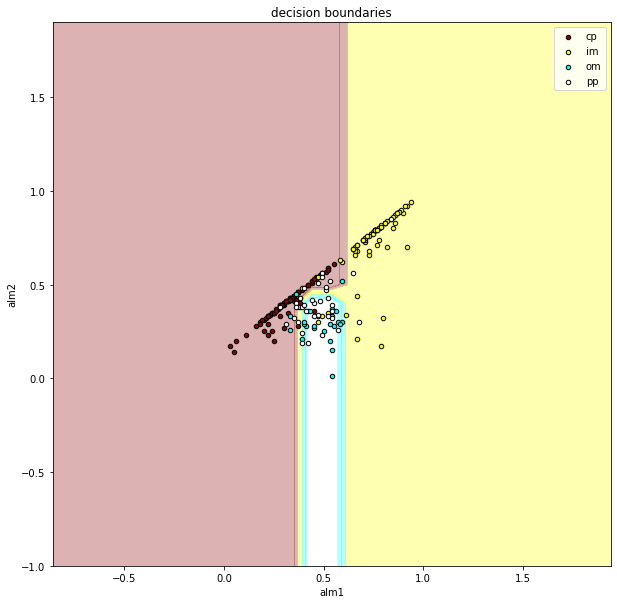

In [17]:
plot_decision_boundaries(clf, X_test, y_test, names=important_features)

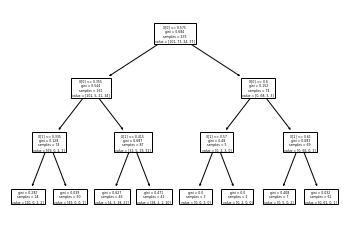

In [18]:
plot_tree(clf);

**6. Построим ансамбли и подберем параметры (по CV):**

- **BaggingClassifier**
- **RandomForestClassifire**
- **AdaBoostClassifire**

Bagging будем делать по деревьям, то есть по умолчанию. Параметр оптимизации - n_estimators

best score = 0.8243195785776998
best n_estimators = 12


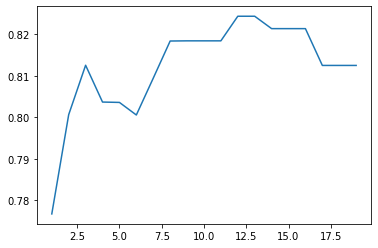

In [19]:
scores = []
n_estimators_list = [i for i in range(1, 20)]
for n_estimators in n_estimators_list:
    bag_clf = BaggingClassifier(n_estimators=n_estimators, random_state=seed)
    score = cross_val_score(bag_clf, X, y)
    scores.append(np.mean(score))
best_score = max(scores)
best_n_estimators = n_estimators_list[scores.index(best_score)]
print(f'best score = {max(scores)}\nbest n_estimators = {best_n_estimators}')
plt.plot(n_estimators_list, scores);

bag_clf = BaggingClassifier(n_estimators=best_n_estimators, random_state=seed)

У RandomForest'a тоже будет оптимизировать n_estimators

best score = 0.8302019315188762
best n_estimators = 16


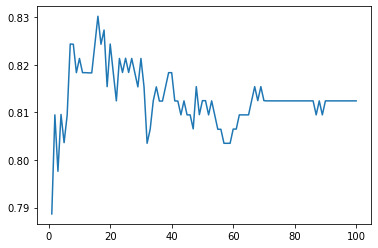

In [20]:
scores = []
n_estimators_list = [i for i in range(1, 101)]
for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
    score = cross_val_score(rf, X, y)
    scores.append(np.mean(score))
best_score = max(scores)
best_n_estimators = n_estimators_list[scores.index(best_score)]
print(f'best score = {max(scores)}\nbest n_estimators = {best_n_estimators}')
plt.plot(n_estimators_list, scores);

rf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=seed)

У AdaBoost помимо n_estimators подберем learning_rate

best score = 0.8183933274802457
best n_estimators = 3
best score = 0.8183933274802457
best learning_rate = 0.96


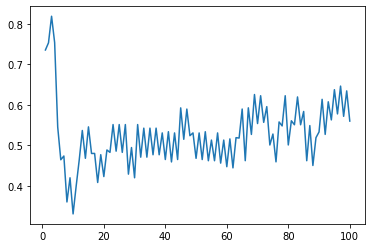

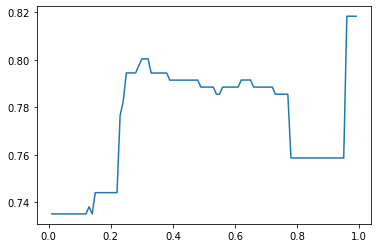

In [21]:
scores = []
n_estimators_list = [i for i in range(1, 101)]
for n_estimators in n_estimators_list:
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators, random_state=seed)
    score = cross_val_score(ada_boost, X, y)
    scores.append(np.mean(score))
best_score = max(scores)
best_n_estimators = n_estimators_list[scores.index(best_score)]
print(f'best score = {max(scores)}\nbest n_estimators = {best_n_estimators}')
plt.subplots()
plt.plot(n_estimators_list, scores);

scores = []
lrs = [0.01 * i for i in range(1, 100)]
for lr in lrs:
    ada_boost = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=lr, random_state=seed)
    score = cross_val_score(ada_boost, X, y)
    scores.append(np.mean(score))
best_score = max(scores)
best_lr = lrs[scores.index(best_score)]
print(f'best score = {max(scores)}\nbest learning_rate = {best_lr}')
plt.subplots()
plt.plot(lrs, scores);

ada_boost = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate=best_lr, random_state=seed)

Визуализируем границу решений для каждого классификатора

Bagging Classifier accuracy = 0.8910891089108911
RandomForest Classifier accuracy = 0.8910891089108911
AdaBoost Classifier accuracy = 0.9405940594059405


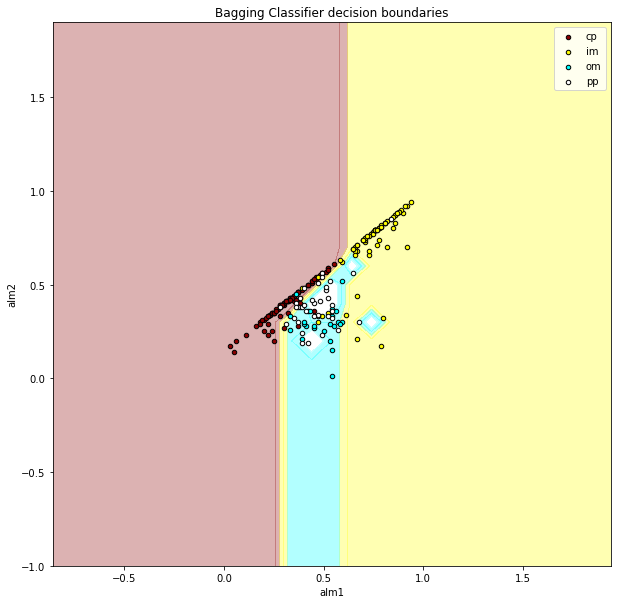

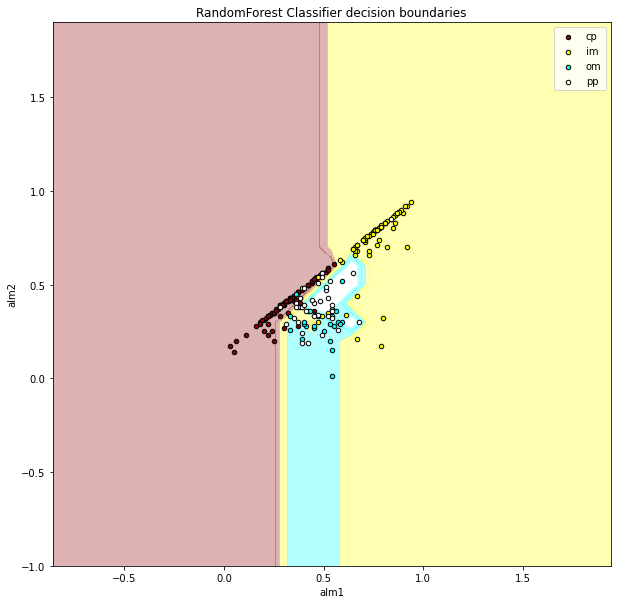

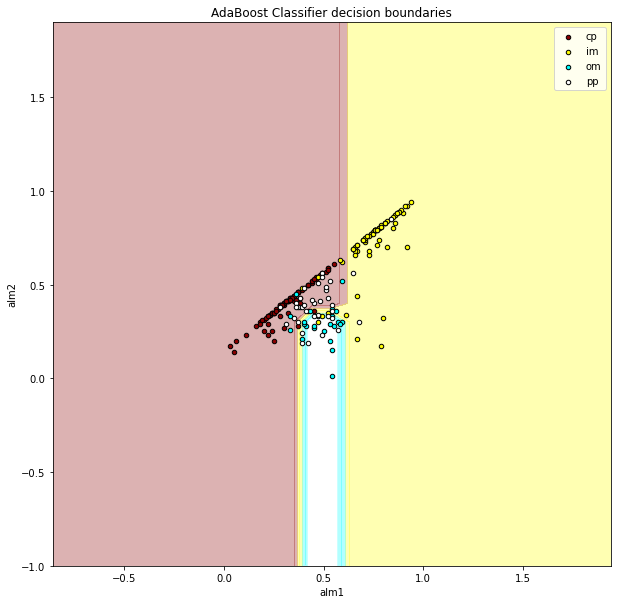

In [22]:
clfs = [bag_clf, rf, ada_boost]
names = ['Bagging Classifier decision boundaries',
         'RandomForest Classifier decision boundaries',
         'AdaBoost Classifier decision boundaries']
for clf, name in zip(clfs, names):
    clf.fit(X_train, y_train)
    score = accuracy(y_test, clf.predict(X_test))
    print(f'{" ".join(name.split()[:2])} accuracy = {score}')
    plot_decision_boundaries(clf, X_test, y_test, names=important_features, title=name)

**7.** Лучше всех себя показал AdaBoost, хотя это не показательно, т.к. датасет слишком маленький и всё слишком зависит от случайного разбиения выборки на трейн/тест. Тем не менее, алгоритмы градиентного бустинга, в том числе и адабуст, являются одними из лучших на табличных данных и всегда показывают лучшие результаты.